# Preparing work

It includes hyper-parameters setting and data processing.

It is worth mentioning that the original data ACM.mat is from a paper that talks about HAN, the author provides a notebook of preprocessing data and has thoughtfully processed it, and the results are placed in data/ACM.

The dataset used for this reproduction is the ACM dataset, which contains 8994 points and 25922 edges, with three node types and four edge types, and the node feature dimension is 1902 dimensions. There are a total of 3025 labeled nodes, of which 600 are divided into training set, 300 are validation set, and 2125 are test set.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import pickle
import torch.nn.functional as F
import math
import time

In [2]:
# import data
with open('data/ACM/node_features.pkl', 'rb') as f:
    node_features = pickle.load(f)  # (8994, 1902)
with open('data/ACM/edges.pkl', 'rb') as f:  # Adjacency matrix of heterogeneous graphs
    edges = pickle.load(f)
with open('data/ACM/labels.pkl', 'rb') as f:
    labels = pickle.load(f)
num_nodes = edges[0].shape[0]
# The length of each adjacency matrix edge is the total number of nodes 
# There are four kinds of edges so there are four edges of the adjacency matrix. len(edges) == 4
# len(labels) == 3 including train/valid/test there are only 3025 labels in total 

In [3]:
# combine edges into one tensor
for i, edge in enumerate(edges):
    if i == 0:
        A = torch.from_numpy(edge.todense()).type(torch.FloatTensor).unsqueeze(-1)
    else:
        tmp = torch.from_numpy(edge.todense()).type(torch.FloatTensor).unsqueeze(-1)
        A = torch.cat([A, tmp], dim=-1)
A = torch.cat([A, torch.eye(num_nodes).type(torch.FloatTensor).unsqueeze(-1)], dim=-1)

node_features = torch.from_numpy(node_features).type(torch.FloatTensor)
train_node = torch.from_numpy(np.array(labels[0][:, 0])).type(torch.LongTensor)
train_target = torch.from_numpy(np.array(labels[0])[:, 1]).type(torch.LongTensor)
valid_node = torch.from_numpy(np.array(labels[1])[:, 0]).type(torch.LongTensor)
valid_target = torch.from_numpy(np.array(labels[1])[:, 1]).type(torch.LongTensor)
test_node = torch.from_numpy(np.array(labels[2])[:, 0]).type(torch.LongTensor)
test_target = torch.from_numpy(np.array(labels[2])[:, 1]).type(torch.LongTensor)

In [4]:
# show data imformation
print('A shape: ', A.shape)
print('node_features shape:', node_features.shape)
print('train_node shape:', train_node.shape)
print('valid_node.shape:', valid_node.shape)
print('test_node.shape', test_node.shape)

A shape:  torch.Size([8994, 8994, 5])
node_features shape: torch.Size([8994, 1902])
train_node shape: torch.Size([600])
valid_node.shape: torch.Size([300])
test_node.shape torch.Size([2125])


In [5]:
# Hyper parameters
epochs = 40
node_dim = 64
num_channels = 2
lr = 0.005
weight_decay = 0.001
num_layers = 2
norm = True
num_classes = torch.max(train_target).item()+1

# Design Model

Including model GTN, the key layer GTLayer, and convolution layer.

In [6]:
class GTN(nn.Module):

    def __init__(self, num_edge, num_channels, w_in, w_out, num_class, num_layers, norm):
        super(GTN, self).__init__()
        self.num_edge = num_edge
        self.num_channels = num_channels
        self.w_in = w_in
        self.w_out = w_out
        self.num_class = num_class
        self.num_layers = num_layers
        self.is_norm = norm
        layers = []
        for i in range(num_layers):  # The layers are composed of multiple GTlayers, which means that the meta-path is aggregated two times.
            if i == 0:
                layers.append(GTLayer(num_edge, num_channels, first=True))  # First GTlayer
            else:
                layers.append(GTLayer(num_edge, num_channels, first=False))  # Second GTlayer
        self.layers = nn.ModuleList(layers)  
        self.weight = nn.Parameter(torch.Tensor(w_in, w_out))  # parameters of GCN
        self.bias = nn.Parameter(torch.Tensor(w_out))
        self.loss = nn.CrossEntropyLoss()
        self.linear1 = nn.Linear(self.w_out * self.num_channels, self.w_out)  # Multi-channel (2*64, 64)
        self.linear2 = nn.Linear(self.w_out, self.num_class)  # Final output
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight)  # gloria initalization
        nn.init.zeros_(self.bias)

    def gcn_conv(self, X, H):
        X = torch.mm(X, self.weight)
        H = self.norm(H, add=True)  # set add as True here because in GCN we should let the adjacency matrix plus the identity matrix
        return torch.mm(H.t(), X)

    def normalization(self, H):
        for i in range(self.num_channels):   # H: (2, 8994, 8994) To normalize each channel of H
            if i == 0:
                H_ = self.norm(H[i, :, :]).unsqueeze(0)   # normalize H[0]
            else:
                H_ = torch.cat((H_, self.norm(H[i, :, :]).unsqueeze(0)), dim=0)  # normalize H[1] and concat them
        return H_

    def norm(self, H, add=False):
        H = H.t()
        if add == False:
            H = H * ((torch.eye(H.shape[0]) == 0).type(torch.FloatTensor))  # Here the value on the diagonal is removed, it represents self-connected edge
        else:
            H = H * ((torch.eye(H.shape[0]) == 0).type(torch.FloatTensor)) + torch.eye(H.shape[0]).type(
                torch.FloatTensor)  # when data come into GCN, add should be set as True. Because in GCN we add identity matrix to adjacency matrix
        deg = torch.sum(H, dim=1)  # shape: (8994,)
        deg_inv = deg.pow(-1)  
        deg_inv[deg_inv == float('inf')] = 0
        deg_inv = deg_inv * torch.eye(H.shape[0]).type(torch.FloatTensor)  # D^(-1)
        H = torch.mm(deg_inv, H)
        H = H.t()
        return H

    def forward(self, A, X, target_x, target):
        A = A.unsqueeze(0).permute(0, 3, 1, 2)  # set output channel (1, 8994, 8994, 5) -> (1, 5, 8994, 8994) 
        Ws = []
        for i in range(self.num_layers):
            if i == 0:
                H, W = self.layers[i](A)
            else:
                H = self.normalization(H)  # normalize A : D-1 * A
                H, W = self.layers[i](A, H)
            Ws.append(W)  # Ws are parameters of convolution layer

        for i in range(self.num_channels):  # do GCN to each channel
            if i == 0:
                X_ = F.relu(self.gcn_conv(X, H[i]))  # X is the node feature matrix
            else:
                X_tmp = F.relu(self.gcn_conv(X, H[i]))
                X_ = torch.cat((X_, X_tmp), dim=1)
        X_ = self.linear1(X_)
        X_ = F.relu(X_)
        y = self.linear2(X_[target_x])
        loss = self.loss(y, target)
        return loss, y, Ws

In [7]:
class GTLayer(nn.Module):

    def __init__(self, in_channels, out_channels, first=True):
        super(GTLayer, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.first = first
        if self.first == True:  # Only the first layer has to be convolved twice
            self.conv1 = GTConv(in_channels, out_channels)  # W1
            self.conv2 = GTConv(in_channels, out_channels)  # W2
        else:
            self.conv1 = GTConv(in_channels, out_channels)  # W3

    def forward(self, A, H_=None):
        if self.first == True:
            a = self.conv1(A)   # a.shape (2, 8994, 8994)
            b = self.conv2(A)   # b.shape (2, 8994, 8994)
            H = torch.bmm(a, b)  # do matrix multiplication to each channel
            W = [(F.softmax(self.conv1.weight, dim=1)).detach(), (F.softmax(self.conv2.weight, dim=1)).detach()] 
        else:
            a = self.conv1(A)
            H = torch.bmm(H_, a)
            W = [(F.softmax(self.conv1.weight, dim=1)).detach()]
        return H, W

In [8]:
class GTConv(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(GTConv, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.weight = nn.Parameter(torch.Tensor(out_channels, in_channels, 1, 1))  # The 1*1 convolution kernel plays the role of dimensionality reduction
        self.bias = None
        self.scale = nn.Parameter(torch.Tensor([0.1]), requires_grad=False)
        self.reset_parameters()

    def reset_parameters(self):
        n = self.in_channels
        nn.init.constant_(self.weight, 0.1)  # initialize parameter as a constant value
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, A):
        '''
        1. F.softmax(self.weight, dim=1) : do softmax to self.weight([2, 5, 1, 1])
        2. A: [1, 5, 8994, 8994] * [2, 5, 1, 1] -> [2, 5, 8994, 8994]
        3. sum: [2, 8994, 8994]
        '''
        A = torch.sum(A * F.softmax(self.weight, dim=1), dim=1)  # do softmax to K=5
        return A

# Train Cycle

Here are the main training cycles.

In [9]:
# Some evaluation functions
def accuracy(pred, target):
    return (pred == target).sum().item() / target.numel()

def true_positive(pred, target, num_classes):
    out = []
    for i in range(num_classes):
        out.append(((pred == i) & (target == i)).sum())

    return torch.tensor(out)    

def true_negative(pred, target, num_classes):
    out = []
    for i in range(num_classes):
        out.append(((pred != i) & (target != i)).sum())

    return torch.tensor(out)

def false_positive(pred, target, num_classes):
    out = []
    for i in range(num_classes):
        out.append(((pred == i) & (target != i)).sum())

    return torch.tensor(out)

def false_negative(pred, target, num_classes):
    out = []
    for i in range(num_classes):
        out.append(((pred != i) & (target == i)).sum())

    return torch.tensor(out)

def precision(pred, target, num_classes):
    tp = true_positive(pred, target, num_classes).to(torch.float)
    fp = false_positive(pred, target, num_classes).to(torch.float)

    out = tp / (tp + fp)
    out[torch.isnan(out)] = 0

    return out

def recall(pred, target, num_classes):
    tp = true_positive(pred, target, num_classes).to(torch.float)
    fn = false_negative(pred, target, num_classes).to(torch.float)

    out = tp / (tp + fn)
    out[torch.isnan(out)] = 0

    return out

def f1_score(pred, target, num_classes):
    prec = precision(pred, target, num_classes)
    rec = recall(pred, target, num_classes)

    score = 2 * (prec * rec) / (prec + rec)
    score[torch.isnan(score)] = 0

    return score

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [10]:
final_f1 = 0
model = GTN(num_edge=A.shape[-1],  # edge types 4+1
            num_channels=num_channels,
            w_in=node_features.shape[1],  # dimension of node features: 1902
            w_out=node_dim,  # hidden output dimension 64
            num_class=num_classes,
            num_layers=num_layers,  # num of layer
            norm=norm)

optimizer = torch.optim.Adam([{'params': model.weight},
                              {'params': model.linear1.parameters()},
                              {'params': model.linear2.parameters()},
                              {"params": model.layers.parameters(), "lr": 0.5}
                              ], lr=0.005, weight_decay=0.001)
loss = nn.CrossEntropyLoss()

# Train & Valid & Test
best_val_loss = 10000
best_test_loss = 10000
best_train_loss = 10000
best_train_f1 = 0
best_val_f1 = 0
best_test_f1 = 0
Train_Loss = []
Valid_Loss = []
Test_Loss = []
Train_F1 = []
Valid_F1 = []
Test_F1 = []

In [11]:
# Train cycle
for i in range(epochs):
    start = time.time()
    for param_group in optimizer.param_groups:
        if param_group['lr'] > 0.005:
            param_group['lr'] = param_group['lr'] * 0.9
    print('Epoch: ', i + 1)
    model.zero_grad()
    model.train()  # A (8994, 8994, 5)
    loss, y_train, Ws = model(A, node_features, train_node, train_target)
    train_f1 = torch.mean(
        f1_score(torch.argmax(y_train.detach(), dim=1), train_target, num_classes=num_classes)).cpu().numpy()
    print('Train - Loss: {}, Macro_F1: {}'.format(loss.detach().cpu().numpy(), train_f1))
    Train_Loss.append(loss.item())
    Train_F1.append(train_f1.tolist())
    loss.backward()
    optimizer.step()
    model.eval()
    # Valid
    with torch.no_grad():
        val_loss, y_valid, _ = model.forward(A, node_features, valid_node, valid_target)
        val_f1 = torch.mean(
            f1_score(torch.argmax(y_valid, dim=1), valid_target, num_classes=num_classes)).cpu().numpy()
        print('Valid - Loss: {}, Macro_F1: {}'.format(val_loss.detach().cpu().numpy(), val_f1))
        Valid_Loss.append(val_loss.item())
        Valid_F1.append(val_f1.tolist())
        test_loss, y_test, W = model.forward(A, node_features, test_node, test_target)
        test_f1 = torch.mean(
            f1_score(torch.argmax(y_test, dim=1), test_target, num_classes=num_classes)).cpu().numpy()
        print('Test - Loss: {}, Macro_F1: {}'.format(test_loss.detach().cpu().numpy(), test_f1))
        Test_Loss.append(test_loss.item())
        Test_F1.append(test_f1.tolist())
    print('Epoch {} takes time: {}\n'.format(i+1, time_since(start)))
    if val_f1 > best_val_f1:
        best_val_loss = val_loss.detach().cpu().numpy()
        best_test_loss = test_loss.detach().cpu().numpy()
        best_train_loss = loss.detach().cpu().numpy()
        best_train_f1 = train_f1
        best_val_f1 = val_f1
        best_test_f1 = test_f1
print('---------------Best Results--------------------')
print('Train - Loss: {}, Macro_F1: {}'.format(best_train_loss, best_train_f1))
print('Valid - Loss: {}, Macro_F1: {}'.format(best_val_loss, best_val_f1))
print('Test - Loss: {}, Macro_F1: {}'.format(best_test_loss, best_test_f1))
final_f1 += best_test_f1

Epoch:  1
Train - Loss: 1.100663661956787, Macro_F1: 0.2082584649324417
Valid - Loss: 1.0749962329864502, Macro_F1: 0.181062713265419
Test - Loss: 1.0698298215866089, Macro_F1: 0.18833695352077484
Epoch 1 takes time: 2m 16s

Epoch:  2
Train - Loss: 1.071734070777893, Macro_F1: 0.18067316710948944
Valid - Loss: 1.0326855182647705, Macro_F1: 0.438032865524292
Test - Loss: 1.0417729616165161, Macro_F1: 0.4145871698856354
Epoch 2 takes time: 2m 14s

Epoch:  3
Train - Loss: 1.0241522789001465, Macro_F1: 0.4365426301956177
Valid - Loss: 0.9507561326026917, Macro_F1: 0.7830908894538879
Test - Loss: 0.9558172821998596, Macro_F1: 0.767535924911499
Epoch 3 takes time: 2m 18s

Epoch:  4
Train - Loss: 0.9386520385742188, Macro_F1: 0.8302190899848938
Valid - Loss: 0.8582612872123718, Macro_F1: 0.5709924697875977
Test - Loss: 0.8620055913925171, Macro_F1: 0.5542786717414856
Epoch 4 takes time: 2m 56s

Epoch:  5
Train - Loss: 0.8378991484642029, Macro_F1: 0.5561205148696899
Valid - Loss: 0.7308017015

Test - Loss: 0.26575908064842224, Macro_F1: 0.9211236834526062
Epoch 37 takes time: 2m 30s

Epoch:  38
Train - Loss: 0.0017697737785056233, Macro_F1: 1.0
Valid - Loss: 0.22208213806152344, Macro_F1: 0.9401862025260925
Test - Loss: 0.265968382358551, Macro_F1: 0.9233503937721252
Epoch 38 takes time: 2m 34s

Epoch:  39
Train - Loss: 0.001509538502432406, Macro_F1: 1.0
Valid - Loss: 0.22656098008155823, Macro_F1: 0.9401307702064514
Test - Loss: 0.2680983245372772, Macro_F1: 0.9242545962333679
Epoch 39 takes time: 2m 32s

Epoch:  40
Train - Loss: 0.0014398798812180758, Macro_F1: 1.0
Valid - Loss: 0.231435626745224, Macro_F1: 0.9300605654716492
Test - Loss: 0.2711946666240692, Macro_F1: 0.9232439398765564
Epoch 40 takes time: 2m 34s

---------------Best Results--------------------
Train - Loss: 0.007618419360369444, Macro_F1: 1.0
Valid - Loss: 0.19927068054676056, Macro_F1: 0.9434779286384583
Test - Loss: 0.23999392986297607, Macro_F1: 0.9239614009857178


In [12]:
print(final_f1)

0.9239614009857178


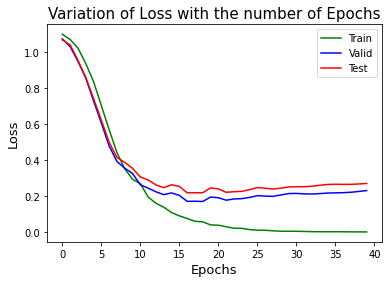

In [13]:
# Loss-Epochs
x = np.arange(40)
y1 = Train_Loss
y2 = Valid_Loss
y3 = Test_Loss

colors=['green', 'blue', 'red']
plt.gca().set_prop_cycle(color=colors)

plt.plot(x,y1,label="Train")
plt.plot(x,y2,label="Valid")
plt.plot(x,y3,label="Test")

plt.title("Variation of Loss with the number of Epochs",fontsize=15)
plt.xlabel("Epochs",fontsize=13)
plt.ylabel("Loss",fontsize=13)
plt.legend()
plt.show()

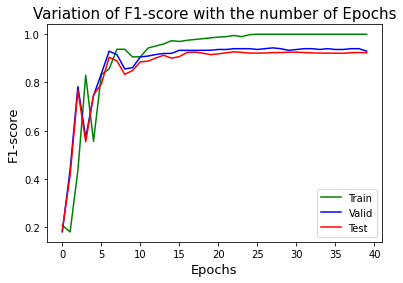

In [17]:
# F1-Epochs
x = np.arange(40)
y4 = Train_F1
y5 = Valid_F1
y6 = Test_F1

colors=['green', 'blue', 'red']
plt.gca().set_prop_cycle(color=colors)

plt.plot(x,y4,label="Train")
plt.plot(x,y5,label="Valid")
plt.plot(x,y6,label="Test")

plt.title("Variation of F1-score with the number of Epochs",fontsize=15)
plt.xlabel("Epochs",fontsize=13)
plt.ylabel("F1-score",fontsize=13)
plt.legend()
plt.show()

In [18]:
torch.save(model.state_dict(), 'GTN_model_0503.pt') # save the model